In [2]:
import sys
sys.path.append("./../../src")
from visualizer_helper import Visualizer
from cluster_helper import ClusterProcessor

import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import scipy
from scipy.sparse import csr_matrix, coo_matrix, triu
from scipy.sparse.linalg import inv
from scipy.stats import entropy

from sklearn.decomposition import PCA
from sklearn.utils.extmath import randomized_svd
from sklearn.cluster import KMeans
from sklearn import preprocessing

import pickle
import os
from collections import Counter

from annoy import AnnoyIndex

from sklearn.metrics import silhouette_samples, silhouette_score

large_file_path = "./../../../large_data_files"
k_neighbors = 50

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ashea2nd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
patient_icd_sparse_path = "./../../data/PATIENT_ICD_BINARY_SPARSE_CSR.p"
pdata = pickle.load(open(patient_icd_sparse_path, "rb"))
pdata.shape

(46520, 6984)

In [6]:
"""
Load the Annoy tree for approximate nearest neighbors.
"""
ANNOY_PATH = "../../../large_data_files"
annoy_path = os.path.join(ANNOY_PATH, "200214_patient_similarity_clusters_default.ann")

cos_knn_tree = AnnoyIndex(pdata.shape[1], "angular")
cos_knn_tree.load(annoy_path)

"""
Build adjacency matrix A.

In first pass, I fill in each row, so A is not yet symetric. I make it symetricin the next code block. 
"""
gamma = 2
print("Building dense data matrix with k={} nn...".format(k_neighbors))
A = np.zeros((pdata.shape[0], pdata.shape[0]))
for i in tqdm(range(pdata.shape[0])):
    #Not including self-loops or self-nearest neighbors via "+1" and [1:]
    nn_idxs = cos_knn_tree.get_nns_by_item(i, k_neighbors + 1)[1:]
    cos_distances = [cos_knn_tree.get_distance(i, nn) for nn in nn_idxs]
    rbf_distances = [np.exp(-gamma*cos_dist**2) for cos_dist in cos_distances]
    A[i, nn_idxs] = rbf_distances

  0%|          | 4/46520 [00:00<19:58, 38.81it/s]

Building dense data matrix with k=50 nn...


100%|██████████| 46520/46520 [09:58<00:00, 77.79it/s]


In [7]:
"""
Make A symetric by only including mutual nearest neighbors
"""

#{Key:Value} = {Patient Index: List of nearest Neighbor indices}
knn_adj = {}

#Populate dictionary
for i in tqdm(range(A.shape[0])):
    nn_idx = set(np.nonzero(A[i])[0])
    knn_adj[i] = nn_idx

#Check for mutual nearest neighbors. 
##Set location to 0 if not mutual nearest neighbors
for i in tqdm(range(A.shape[0])):
    nns = knn_adj[i]
    for nn in nns:
        if i not in knn_adj[nn]:
            A[i, nn] = 0
            knn_adj[]

pickle.dump(csr_matrix(A), open("./data/A_FULL_mknn_K{}_CSR.p".format(k_neighbors), "wb"))

100%|██████████| 46520/46520 [00:01<00:00, 25776.28it/s]


# A loading

In [21]:
A = pickle.load(open("./data/A_FULL_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
A.shape

(46520, 46520)

In [22]:
"""Sanity Check: Matrix is indeed symetric"""
print(np.array_equal(A.data, A.T.data))
print(np.array_equal(A.indices, A.T.indices))

True
True


In [23]:
k_neighbors = 50
# A = pickle.load(open("./data/A_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

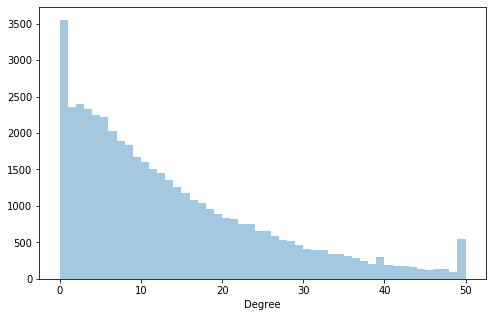

In [24]:
"""Plot the distribution of nearest neighbors"""
plt.figure(figsize=(8,5))
ax = sns.distplot(np.count_nonzero(A.toarray(), axis=0), kde=False)
ax.set(xlabel="Degree")
plt.savefig("./figures/mknn_featdist_K{}_RAW.png".format(k_neighbors))

### A: remove empty patients and outliers

In [25]:
"""
Remove patients without any nearest neighbors
Remove patients with full (50) nearest neighbors. The communities can be thought of as "outliers"
"""

#Works because A is symetric
rows_with_vals = np.unique(A.indices)

A_nonempty = A[rows_with_vals][:, rows_with_vals]
print(type(A_nonempty))
print("Shape after removing empty patients:", A_nonempty.shape)

<class 'scipy.sparse.csr.csr_matrix'>
Shape after removing empty patients: (42970, 42970)


[Text(0.5, 0, 'Degree')]

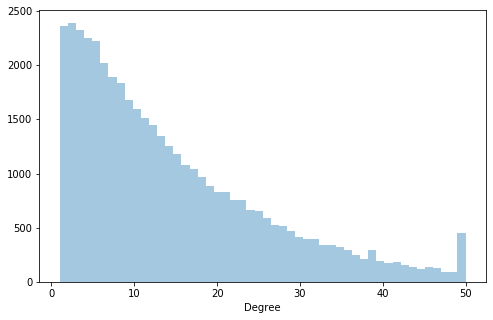

In [26]:
"""Plot the distribution with empty patients removed"""
plt.figure(figsize=(8,5))
ax = sns.distplot(np.count_nonzero(A_nonempty.toarray(), axis=0), kde=False)
ax.set(xlabel="Degree")

In [27]:
"""
Remove patients with k_neighbors nearest neighbors. 
"""

patient_degrees = np.count_nonzero(A_nonempty.toarray(), axis=0)

#Sanity check to ensure all empty patients have been removed
print(patient_degrees.shape)

threshold = k_neighbors
degree_threshold_idx = np.argwhere(patient_degrees < threshold)[:, 0]

#Another sanity check
print(degree_threshold_idx)
print(degree_threshold_idx.shape)

(42970,)
[    0     1     2 ... 42967 42968 42969]
(42517,)


In [30]:
#Only include patients with < k_neighbors nearest neighbors
A_cleaned = A_nonempty[degree_threshold_idx][:, degree_threshold_idx]
print("Before shape:", A_nonempty.shape)
print("After shape:", A_cleaned.shape)

Before shape: (42970, 42970)
After shape: (42517, 42517)


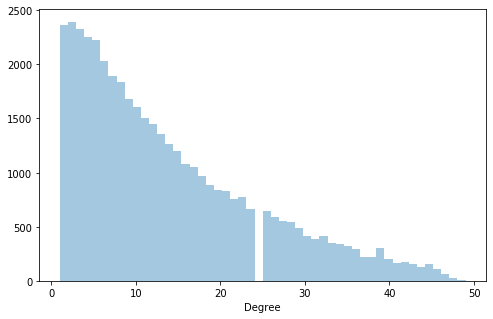

In [31]:
"""Plot the distribution with empty patients and very dense patients removed"""
plt.figure(figsize=(8,5))
ax = sns.distplot(np.count_nonzero(A_cleaned.toarray(), axis=0), kde=False)
ax.set(xlabel="Degree")
plt.savefig("./figures/mknn_featdist_K{}_emptyandoutliersremoved.png".format(k_neighbors))

In [18]:
"""
Save all indexing information for final analysis
"""
#PATIENT_ICD_SUBJECT_IDS maps the "matrix row index" to "patient id"
##We want to keep track of which patients are remaining and which were removed
remaining_subject_ids = pd.read_csv("../../data/PATIENT_ICD_SUBJECT_IDS.csv")
remaining_subject_ids

,SUBJECT_ID
0,109
1,112
2,113
3,114
4,115
...,...
46515,97164
46516,97484
46517,97488
46518,97492


In [ ]:
"""ONLY RUN IF first pass, OTHERWISE skip to next block to load pre-computed indexing file"""
remaining_subject_ids_cleaned = remaining_subject_ids.iloc[rows_with_vals].iloc[degree_threshold_idx]
remaining_subject_ids_cleaned["ORIGINAL_INDEX"] = remaining_subject_ids_cleaned.index
remaining_subject_ids_cleaned.to_csv("./data/REMAINING_SUBJECT_IDS.csv", index=None)

In [16]:
"""
SUBJECT_ID = Patient ID
ORIGINAL_INDEX = Corresponding row index in original, un-processed 46520x46520 adjacency matrix

Important because we can now map indices between the processed adjacency matrix to the original adjacency matrix
"""
remaining_subject_ids = pd.read_csv("./data/REMAINING_SUBJECT_IDS.csv")
remaining_subject_ids

,SUBJECT_ID,ORIGINAL_INDEX
0,109,0
1,112,1
2,113,2
3,114,3
4,115,4
...,...,...
42512,97164,46515
42513,97484,46516
42514,97488,46517
42515,97492,46518


## A rescaling

In [33]:
"""
We rescale and increase values in A to prevent numerical errors later in the pipeline. 

Before, the values in A are small between 0-1. After, they are larger between 1-7.38
"""
A = A_cleaned
print(np.min(A), np.max(A))
print(A.data)
print(A.shape)

0.0 1.0
[0.06656105 0.05220621 0.04366442 ... 0.06948346 0.05569175 0.06488823]
(42517, 42517)


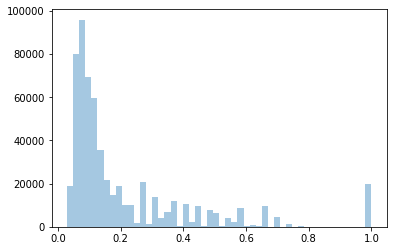

In [35]:
nonzero_idx_A = np.nonzero(A.toarray())

"""Distribution of unscaled data"""
sns.distplot(A[nonzero_idx_A], kde=False)

In [36]:
"""
Rescaling done exponentially has the benefit of accentuating similarity differences in the similarity matrix.
"""
rescaled_data = np.exp(2*A[nonzero_idx_A])

[[1.14238949 1.11005817 1.09125547 ... 1.14908608 1.11782351 1.13857383]]
1.0587944922327113 7.38905609893065


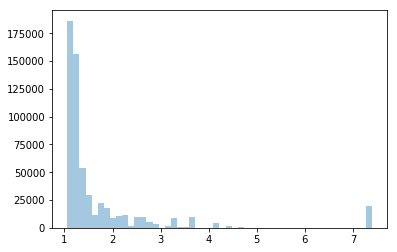

In [43]:
sns.distplot(rescaled_data, kde=False)
print(rescaled_data)
print(np.min(rescaled_data), np.max(rescaled_data))

In [37]:
#Save rescaled data
A_rescaled = A.copy().toarray()
A_rescaled[nonzero_idx_A] = rescaled_data
A_rescaled = csr_matrix(A_rescaled)
print(A_rescaled.min(), A_rescaled.max())

0.0 7.38905609893065


In [45]:
pickle.dump(csr_matrix(A_rescaled), open("./data/A_mknn_K{}_CSR.p".format(k_neighbors), "wb"))

In [38]:
A = pickle.load(open("./data/A_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
print(A.shape)
print(A.min(), A.max())

(42517, 42517)
0.0 7.38905609893065


# D

In [47]:
"""
D matrix computed by summing rows of A according to Ng et. al.
https://ai.stanford.edu/~ang/papers/nips01-spectral.pdf
"""
D = np.zeros((A.shape[0], A.shape[0]))
for i in tqdm(range(A.shape[0])):
    D[i, i] = np.sum(A[i])
    
pickle.dump(csr_matrix(D), open("./data/D_mknn_K{}_CSR.p".format(k_neighbors), "wb"))

100%|██████████| 42517/42517 [00:09<00:00, 4278.44it/s]


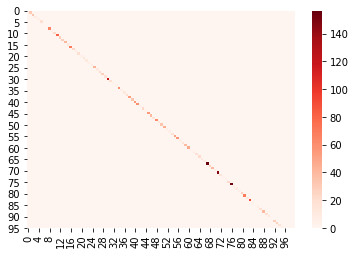

In [39]:
D = pickle.load(open("./data/D_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
sns.heatmap(D[:100, :100].toarray(), cmap="Reds")

# D_mc (poor variable name for degree-corrected D)

In [41]:
"""
Degree-corrected acts as regularization and theoretically reduces the outlier effect of highly-connected patients 
"""
k_neighbors = 50

In [44]:
diag_idx = np.diag_indices(D.shape[0])
D_mean = np.mean(D[diag_idx])

D_mc = D.copy()
D_mc[diag_idx] = D[diag_idx] + D_mean
print(np.mean(D_mc[diag_idx]), np.mean(D[diag_idx]))

47.203751839879196 23.6018759199396


In [51]:
pickle.dump(csr_matrix(D_mc), open("./data/D_mc_mknn_K{}_CSR.p".format(k_neighbors), "wb"))

# D_inv_sqrt

In [42]:
"""
Compute D^(-1/2) according to Ng et. al.
https://ai.stanford.edu/~ang/papers/nips01-spectral.pdf
"""

k_neighbors = 50

In [45]:
D = pickle.load(open("./data/D_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
D_mc = pickle.load(open("./data/D_mc_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
print(D.shape, D_mc.shape)
print(np.mean(D[diag_idx]), np.mean(D_mc[diag_idx]))
print(np.mean(D), np.mean(D_mc))

(42517, 42517) (42517, 42517)
23.6018759199396 47.203751839879196
0.000555116210455573 0.0011102324209111463


In [54]:
def get_inv_sqrt(d):
    #Only divide by nonzero values to prevent nan errors. 
    nonzero_idx = np.nonzero(d)
    d_diag_sqrt_inv = 1.0/np.sqrt(d[nonzero_idx])
    d_inv_sqrt = d.copy()
    d_inv_sqrt[nonzero_idx] = d_diag_sqrt_inv
    return d_inv_sqrt

D_inv_sqrt = get_inv_sqrt(D)
D_mc_inv_sqrt = get_inv_sqrt(D_mc)

In [55]:
pickle.dump(D_inv_sqrt, open("./data/D_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "wb"))
pickle.dump(D_mc_inv_sqrt, open("./data/D_mc_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "wb"))

# Compute normalized L

In [56]:
"""
L and L_mc are both calculated according to Ng et. al. with their respective matrices.
https://ai.stanford.edu/~ang/papers/nips01-spectral.pdf

L_mc = degree corrected L
"""
k_neighbors = 50

In [57]:
A = pickle.load(open("./data/A_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
D_inv_sqrt = pickle.load(open("./data/D_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "rb"))
D_mc_inv_sqrt = pickle.load(open("./data/D_mc_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "rb"))
print(A.shape, D.shape, D_mc.shape)

L = D_inv_sqrt.dot(A.dot(D_inv_sqrt))
L_mc = D_mc_inv_sqrt.dot(A.dot(D_mc_inv_sqrt))

pickle.dump(csr_matrix(L), open("./data/L_mknn_K{}_CSR.p".format(k_neighbors), "wb"))
pickle.dump(csr_matrix(L_mc), open("./data/L_mc_mknn_K{}_CSR.p".format(k_neighbors), "wb"))

(42517, 42517) (42517, 42517) (42517, 42517)


In [58]:
"""The reduced range of L_mc is expected (Increasing values of D_mc => Decreasing inverse of D_mc)"""
print(L.shape, L_mc.shape)
print(np.min(L), np.max(L))
print(np.min(L_mc), np.max(L_mc))

(42517, 42517) (42517, 42517)
0.0 1.0000000000000002
0.0 0.23842639177264768



# Eigen Decomposition

In [3]:
L = pickle.load(open("./data/L_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
L_mc = pickle.load(open("./data/L_mc_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

evecs=2000
L_evecs, L_evals, _ = randomized_svd(L, n_components=evecs)
L_mc_evecs, L_mc_evals, _ = randomized_svd(L_mc, n_components=evecs)
# pickle.dump(L_evecs, open("./data/L_evecs{}_K{}.p".format(evecs, k_neighbors), 'wb'))
# pickle.dump(L_mc_evecs, open("./data/L_mc_evecs{}_K{}.p".format(evecs, k_neighbors), "wb"))
# pickle.dump(L_evals, open("./data/L_evals{}_K{}.p".format(evecs, k_neighbors), "wb"))
# pickle.dump(L_mc_evals, open("./data/L_mc_evals{}_K{}.p".format(evecs, k_neighbors), "wb"))

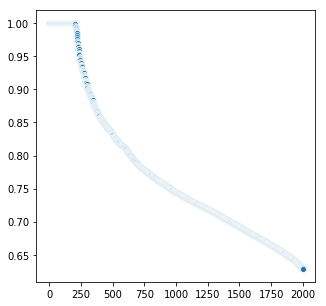

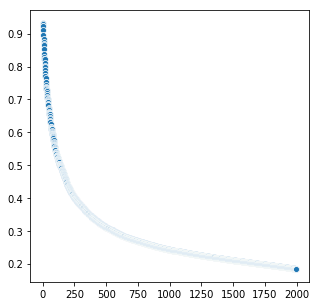

In [4]:
#print(np.flip(L_evals_svd))
plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_evals.shape[0]), L_evals)
# plt.savefig("./figures/L_EVALS{}.png".format(evecs))

#print(np.flip(L_mc_evals_svd))
plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_mc_evals.shape[0]), L_mc_evals)
# plt.savefig("./figures/L_mc_EVALS{}.png".format(evecs))

In [16]:
pickle.dump(L_evecs, open("./data/L_evecs{}_K{}.p".format(evecs, k_neighbors), 'wb'))
pickle.dump(L_mc_evecs, open("./data/L_mc_evecs{}_K{}.p".format(evecs, k_neighbors), "wb"))
pickle.dump(L_evals, open("./data/L_evals{}_K{}.p".format(evecs, k_neighbors), "wb"))
pickle.dump(L_mc_evals, open("./data/L_mc_evals{}_K{}.p".format(evecs, k_neighbors), "wb"))

In [23]:
"""
NOTE: Based on the plots above, we the eigenvectors corresponding to highly relevant eigenvalues. 

L: Eigenvectors 0-250
L_mc: Eigenvectors 0-300
"""
L_evecs = pickle.load(open("./../../../large_data_files/L_evecs2000_K50.p","rb"))
L_evecs_top = L_evecs[:, 0:300]
#L_mc_evecs_top = L_mc_evecs[:, :300]
pickle.dump(L_evecs_top, open("./data/TOP_L_evecs{}_0_300_K{}.p".format(evecs, k_neighbors), 'wb'))
#pickle.dump(L_mc_evecs_top, open("./data/TOP_L_mc_evecs{}_0_300_K{}.p".format(evecs, k_neighbors), "wb"))

In [61]:
"""
evecs_to_plot=20
L_k_evecs = L_evecs[:, -evecs_to_plot:]
L_mc_k_evecs = L_mc_evecs[:, -evecs_to_plot:]

evec_cols = ["Evec_{}".format(i) for i in range(evecs_to_plot)]

L_evec_df = pd.DataFrame(L_k_evecs, columns=evec_cols)
L_mc_evec_df = pd.DataFrame(L_mc_k_evecs, columns=evec_cols)
print(L_evec_df.describe())
print(L_mc_evec_df.describe())
"""

             Evec_0        Evec_1        Evec_2        Evec_3        Evec_4  \
count  42517.000000  42517.000000  42517.000000  42517.000000  42517.000000   
mean       0.000164      0.000051      0.000480     -0.000257     -0.000085   
std        0.004847      0.004850      0.004826      0.004843      0.004849   
min       -0.134232     -0.190371     -0.164643     -0.162099     -0.182411   
25%       -0.000254     -0.000187      0.000147     -0.000459     -0.000430   
50%        0.000021      0.000119      0.000431      0.000100     -0.000159   
75%        0.000322      0.000428      0.000884      0.000528      0.000059   
max        0.177969      0.215234      0.219077      0.193335      0.186981   

             Evec_5        Evec_6        Evec_7        Evec_8        Evec_9  \
count  42517.000000  42517.000000  42517.000000  42517.000000  42517.000000   
mean      -0.000119     -0.000113     -0.000028     -0.000107      0.000281   
std        0.004848      0.004848      0.004850    

# K-Means clustering

In [24]:
A_file = "A_mknn_K50_CSR.p"

D_file = "D_mknn_K50_CSR.p"
D_mc_file = "D_mc_mknn_K50_CSR.p"

L_file = "L_mknn_K50_CSR.p"
L_eval_file = "L_evals2000_K50.p"
L_evec_file = "TOP_L_evecs2000_0_300_K50.p"

L_mc_file = "L_mc_mknn_K50_CSR.p"
L_mc_eval_file = "L_mc_evals2000_K50.p"
L_mc_evec_file = "TOP_L_mc_evecs2000_0_250_K50.p"

In [25]:
"""
Load relevant matrices.

NOTE on features kept:

L: eigenvectors 250-500 
L_mc: eigenvectors 0-500
"""

A = pickle.load(open("./data/{}".format(A_file), "rb"))

D = pickle.load(open("./data/{}".format(D_file), "rb"))
D_mc = pickle.load(open("./data/{}".format(D_mc_file), "rb"))

L = pickle.load(open("./data/{}".format(L_file), "rb"))
L_eval = pickle.load(open("./data/{}".format(L_eval_file), "rb"))
L_evec = pickle.load(open("./data/{}".format(L_evec_file), 'rb'))

L_mc = pickle.load(open("./data/{}".format(L_mc_file), "rb"))
L_mc_eval = pickle.load(open("./data/{}".format(L_mc_eval_file), "rb"))
L_mc_evec = pickle.load(open("./data/{}".format(L_mc_evec_file), "rb"))

print(L_eval.shape, L_evec.shape)
print(L_mc_eval.shape, L_mc_evec.shape)

(2000,) (42517, 300)
(2000,) (42517, 250)


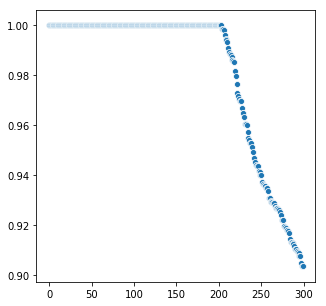

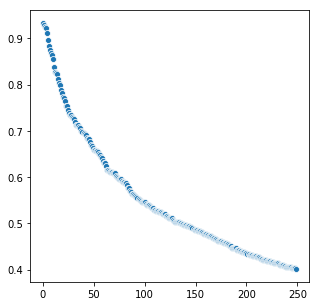

In [26]:
"""
Grab corresponding eigenvalues and plot them separately
"""
L_eval_kept = L_eval[0:300]
L_mc_eval_kept = L_mc_eval[:250]

plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_eval_kept.shape[0]), L_eval_kept)
plt.savefig("./figures/L_EVALS{}_0_300.png".format(evecs))

plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_mc_eval_kept.shape[0]), L_mc_eval_kept)
plt.savefig("./figures/L_mc_EVALS{}_0_250.png".format(evecs))

In [27]:
"""
Renormalize the Laplacian eigenvectors to obtain feature vectors according to Ng et. al.
https://ai.stanford.edu/~ang/papers/nips01-spectral.pdf
"""

def renormalize_X(X):
    evecs_lengths = np.linalg.norm(X, axis=1)
    Y = X / evecs_lengths[:, None]
    return Y[~np.isnan(Y).any(axis=1)]

f=300
L_evec_top = L_evec[:, :f]
L_mc_evec_top = L_mc_evec[:, :f]

Y = renormalize_X(L_evec_top)
Y_mc = renormalize_X(L_mc_evec_top)

print(Y.shape, Y_mc.shape)

(42517, 300) (42517, 250)


In [28]:
pickle.dump(Y, open("./data/Y_f{}.p".format(f), "wb"))
pickle.dump(Y_mc, open("./data/Y_mc_f{}.p".format(f), "wb"))

In [30]:
knn_sizes_to_test = [30, 50, 100, 200, 300]

Y_sil_scores = []
Y_mc_sil_scores = []

for knn_clusters in knn_sizes_to_test:
    print("running Kmeans K={}...".format(knn_clusters))
    
    Y_kmeans = KMeans(n_clusters=knn_clusters).fit(Y)
    Y_mc_kmeans = KMeans(n_clusters=knn_clusters).fit(Y_mc)

    Y_cluster_labels = Y_kmeans.labels_    
    Y_mc_cluster_labels = Y_mc_kmeans.labels_
    
    pickle.dump(Y_cluster_labels, open("./data/cluster_labels_Y_{}feats_k{}.p".format(f, knn_clusters), 'wb'))
    pickle.dump(Y_mc_cluster_labels, open("./data/cluster_labels_Y_mc_{}feats_k{}.p".format(f, knn_clusters), 'wb'))    

    Y_sil_score = silhouette_score(Y, Y_cluster_labels)
    Y_mc_sil_score = silhouette_score(Y_mc, Y_mc_cluster_labels)

    Y_sil_scores.append(Y_sil_score)
    Y_mc_sil_scores.append(Y_mc_sil_score)
    
    print(knn_clusters, Y_sil_score, Y_mc_sil_score)

running Kmeans K=30...
30 0.3177563190216646 0.1785695123830247
running Kmeans K=50...
50 0.2996377273168373 0.20731443286815732
running Kmeans K=100...
100 0.282925616363824 0.22760686525024057
running Kmeans K=200...
200 0.26873816364713443 0.2515429726979012
running Kmeans K=300...
300 0.253050632341822 0.2531472252143535


Text(0.5,0,'knn clusters')

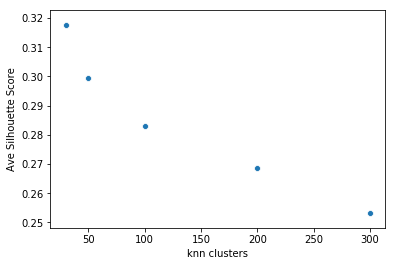

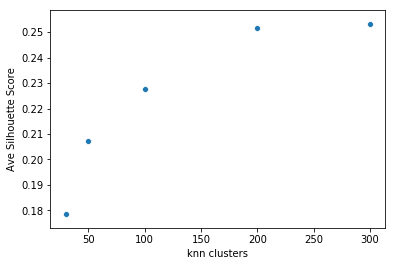

In [31]:
pickle.dump(Y_sil_scores, open("./data/sil_scores_Y_{}feats.p".format(f), 'wb'))
pickle.dump(Y_mc_sil_scores, open("./data/sil_scores_Y_mc_{}feats.p".format(f), 'wb'))

plt.figure()
ax = sns.scatterplot(knn_sizes_to_test, Y_sil_scores)
ax.set_ylabel("Ave Silhouette Score")
ax.set_xlabel("knn clusters")
#plt.savefig("./figures/silscores_Y_{}feats.png".format(f))

plt.figure()
ax = sns.scatterplot(knn_sizes_to_test, Y_mc_sil_scores)
ax.set_ylabel("Ave Silhouette Score")
ax.set_xlabel("knn clusters")
#plt.savefig("./figures/silscores_Y_mc_{}feats.png".format(f))

In [106]:
f=50
pickle.load(open("./data/sil_scores_Y_{}feats.p".format(f), 'rb'))

[0.4362220330638627,
 0.40829918520953723,
 0.40307962789271956,
 0.3712030846995727,
 0.3421145882295371,
 0.29320033738494566]

In [35]:
Y_feats = 300
Y_knn_clusters = 200

Y_mc_feats = 20
Y_mc_knn_clusters = 30

Y_cluster_labels_best = pickle.load(open("./data/cluster_labels_Y_{}feats_k{}.p".format(Y_feats, Y_knn_clusters), 'rb'))
Y_mc_cluster_labels_best = pickle.load(open("./data/cluster_labels_Y_mc_{}feats_k{}.p".format(Y_mc_feats, Y_mc_knn_clusters), 'rb'))

In [36]:
Y_cluster_labels = Y_cluster_labels_best
Y_mc_cluster_labels = Y_mc_cluster_labels_best
print(Y_cluster_labels.shape, Y_mc_cluster_labels.shape)

(42517,) (42517,)


In [37]:
### Save cluster assignments
cluster_assignment_df = pd.read_csv("./data/REMAINING_SUBJECT_IDS.csv")

print(cluster_assignment_df.shape)
print(Y_cluster_labels.shape)

cluster_assignment_df["CLUSTER"] = Y_cluster_labels
cluster_assignment_df["MC_CLUSTER"] = Y_mc_cluster_labels

print(cluster_assignment_df)
cluster_assignment_df.to_csv("./data/CLUSTER_ASSIGNMENTS_k{}.csv".format(Y_knn_clusters), index=None)

(42517, 2)
(42517,)
       SUBJECT_ID  ORIGINAL_INDEX  CLUSTER  MC_CLUSTER
0             109               0       50           0
1             112               1      179           0
2             113               2       30           0
3             114               3      151           0
4             115               4       45           0
5             117               6       43           0
6             119               8       65           0
7             122              10      176           5
8             123              11      139           0
9             124              12      152           0
10            125              13      169           0
11            126              14       77           1
12            127              15      158           0
13            128              16      149          16
14            129              17       65           0
15            130              18      132           0
16            131              19       14   

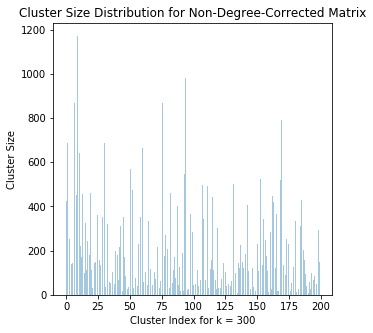

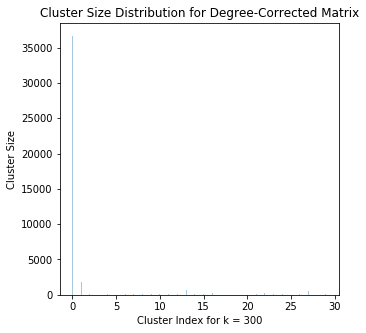

In [38]:
plt.figure(figsize=(5,5))
sns.distplot(Y_cluster_labels, bins=knn_clusters, kde=False)
plt.title("Cluster Size Distribution for Non-Degree-Corrected Matrix")
plt.xlabel("Cluster Index for k = {}".format(knn_clusters))
plt.ylabel("Cluster Size")
plt.savefig("./figures/cluster_size_distr_Y_k{}.png".format(Y_knn_clusters))

plt.figure(figsize=(5,5))
sns.distplot(Y_mc_cluster_labels, bins=knn_clusters, kde=False)
plt.title("Cluster Size Distribution for Degree-Corrected Matrix")
plt.xlabel("Cluster Index for k = {}".format(knn_clusters))
plt.ylabel("Cluster Size")
plt.savefig("./figures/cluster_size_distr_Y_mc_k{}.png".format(Y_mc_knn_clusters))

# Analyze Clusters

In [39]:
icd_to_phecode = pd.read_csv("./phecode_icd9_map_unrolled.csv")
phecode_definitions = pd.read_csv("./phecode_definitions.csv")
cluster_assignments = pd.read_csv("./data/CLUSTER_ASSIGNMENTS_k{}.csv".format(Y_knn_clusters))

In [40]:
print(cluster_assignments.head())

   SUBJECT_ID  ORIGINAL_INDEX  CLUSTER  MC_CLUSTER
0         109               0       50           0
1         112               1      179           0
2         113               2       30           0
3         114               3      151           0
4         115               4       45           0


### Heatmap Analysis

In [41]:
"""

I examine small, medium, and large clusters to see how well they capture different types of patients

Small, medium, and large are defined based on quartiles of cluster sizes

"""

'\n\nI examine small, medium, and large clusters to see how well they capture different types of patients\n\nSmall, medium, and large are defined based on quartiles of cluster sizes\n\n'

In [52]:
patient_icd_binary = pickle.load(open("../../data/PATIENT_ICD_BINARY_SPARSE_CSR.p", 'rb'))

icd9codes = pd.read_csv("../../data/PATIENT_ICD_ICD9_CODES.csv")
icd9diag = pd.read_csv("../../../mimic/D_ICD_DIAGNOSES.csv.gz")

"""
Helper function called by feats_for_cluster(). 
Returns a dataframe with data for the top occuring ICD codes in a cluster

Data Includes:

-Top icd titles
-Cluster number
-ICD Code
-ICD Frequency
-ICD Frequency as percentage
-ICD's LONG_TITE
-Custom ICD title (used for heatmap plotting)
"""
def top_cluster_feats(cluster_i, n_top_feats=10):
    #Find most common ICD codes
    pidx_in_cluster_i = cluster_assignments[cluster_assignments["CLUSTER"] == cluster_i]['ORIGINAL_INDEX']
    pfeats_in_cluster_i = patient_icd_binary[pidx_in_cluster_i]
    pfeats_distr_in_cluster_i = np.asarray(pfeats_in_cluster_i.sum(axis=0))

    icd9codes_aslist = icd9codes["ICD9_CODE"].tolist()

    icd_freq_pairs_in_cluster_i = list(zip(icd9codes_aslist, pfeats_distr_in_cluster_i[0]))
    icd_freq_pairs_in_cluster_i = sorted(icd_freq_pairs_in_cluster_i, key=lambda p: p[1], reverse=True)
    
    #Use only the top n ICD9 codes
    top_icds_freqs_in_cluster_i = icd_freq_pairs_in_cluster_i[:n_top_feats]
    
    top_icds_in_cluster_i = [p[0] for p in top_icds_freqs_in_cluster_i]
    top_freqs_in_cluster_i = [p[1] for p in top_icds_freqs_in_cluster_i]

    #There may be a bug in the MIMIC-III dataset, hence the try-except
    ##Note this doesn't really affect end results
    top_icd9_titles = []
    missing_icd_idx = []
    for idx, icd in enumerate(top_icds_in_cluster_i):
        try:
            long_title = icd9diag[icd9diag['ICD9_CODE'] == icd]["LONG_TITLE"].values[0]
            top_icd9_titles.append(long_title)
        except:
            print("No data found for ICD code {}".format(icd))
            missing_icd_idx.append(idx)
            n_top_feats -= 1
            pass
    
#     print("BEFORE")
#     print(top_icds_in_cluster_i)
#     print(top_freqs_in_cluster_i)
#     print(top_icd9_titles)
#     print(n_top_feats)
#     print(missing_icd_idx)
    
    top_icds_in_cluster_i = [top_icds_in_cluster_i[i] for i in range(len(top_icds_in_cluster_i)) if i not in missing_icd_idx]
    top_freqs_in_cluster_i = [top_freqs_in_cluster_i[i] for i in range(len(top_freqs_in_cluster_i)) if i not in missing_icd_idx]

    sum_top_feats_in_cluster_i = np.sum(top_freqs_in_cluster_i)
    top_icd_percent_occurence_in_cluster_i = [float(f)/sum_top_feats_in_cluster_i for f in top_freqs_in_cluster_i]
    
#     print("AFTER")
#     print(top_icds_in_cluster_i)
#     print(top_freqs_in_cluster_i)
#     print(top_icd_percent_occurence_in_cluster_i)
#     print(top_icd9_titles)
#     print(n_top_feats)
#     print(missing_icd_idx)
    
    icd_title_strs_in_cluster_i = ["icd:{}_{}".format(top_icds_in_cluster_i[p], top_icd9_titles[p]) for p in range(n_top_feats)]
    top_feats_in_cluster_i_dict = {"CLUSTER": [cluster_i] * n_top_feats, 
                                   "ICD9_CODE": top_icds_in_cluster_i, 
                                   "ICD9_FREQS": top_freqs_in_cluster_i,
                                   "ICD9_PERCENTAGE": top_icd_percent_occurence_in_cluster_i, 
                                   "LONG_TITLE": top_icd9_titles, 
                                   "ICD_TITLE": icd_title_strs_in_cluster_i}

    top_feats_in_cluster_i_df = pd.DataFrame(top_feats_in_cluster_i_dict)
    return top_feats_in_cluster_i_df

"""
Creates a DataFrame that is used to generate heatmap for specific clusters.
"""
def feats_for_clusters(specific_clusters_of_interest):
    cluster_dfs = []
    for ci in specific_clusters_of_interest:
        ci_df = top_cluster_feats(ci, 5)
        cluster_dfs.append(ci_df)

    cluster_dfs = pd.concat(cluster_dfs)
    unique_icd9codes = pd.unique(cluster_dfs["ICD9_CODE"])
    
    #This mapping is used to map an ICD to a consistent index
    ##This helps with plotting later on
    icd_idx_mapping = {k: v for v, k in enumerate(unique_icd9codes)}
    
    icd_to_icd_title_mapping = {}
    for icd in unique_icd9codes:
        icd_title = cluster_dfs[cluster_dfs["ICD9_CODE"] == icd]["ICD_TITLE"].values[0]
        icd_to_icd_title_mapping[icd] = icd_title
        
    percentage_dfs = []

    for ci in specific_clusters_of_interest:
        #percentage_vec = np.zeros(len(icd_idx_mapping))

        c_df = cluster_dfs[cluster_dfs["CLUSTER"] == ci]
        c_icds = c_df["ICD9_CODE"].tolist()
        c_percentages = c_df["ICD9_PERCENTAGE"].tolist()

        percentage_vec = np.zeros(len(icd_idx_mapping))
        #Populate the percentage vector with values
        for i, icd in enumerate(c_icds):
            icd_idx = icd_idx_mapping[icd]
            percentage_vec[icd_idx] = c_percentages[i]

        #Use percentage vector to build a dataframe row    
        icd_percentage_pairs = []
        for icd, icd_idx in icd_idx_mapping.items():
            icd_title = icd_to_icd_title_mapping[icd]
            percentage = percentage_vec[icd_idx]
            icd_percentage_pairs.append((icd_title, percentage))
            
        cluster_feat_row = dict(icd_percentage_pairs)
        cluster_feat_row["CLUSTER"] = "C{}".format(ci)
        cluster_percentages_df = pd.DataFrame([cluster_feat_row])
        percentage_dfs.append(cluster_percentages_df)
        
    return pd.concat(percentage_dfs)
   
#Visualize top ICDs => make sure ~5-10 are highly enriched
def heatmap_clusters(cluster_percentage_df, title):
    heatmap_data = cluster_percentage_df.drop("CLUSTER", axis=1).transpose()
    plt.figure(figsize=(5,10))
    g = sns.heatmap(heatmap_data, cmap="Reds", linewidths=2)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
    g.set_xticklabels(cluster_percentage_df['CLUSTER'])
    g.set_title(title, fontsize=15)
    plt.savefig("./heatmaps/heatmap_{}.png".format(title), bbox_inches='tight')

(42517,) (42517,)


Text(0,0.5,'Cluster Size')

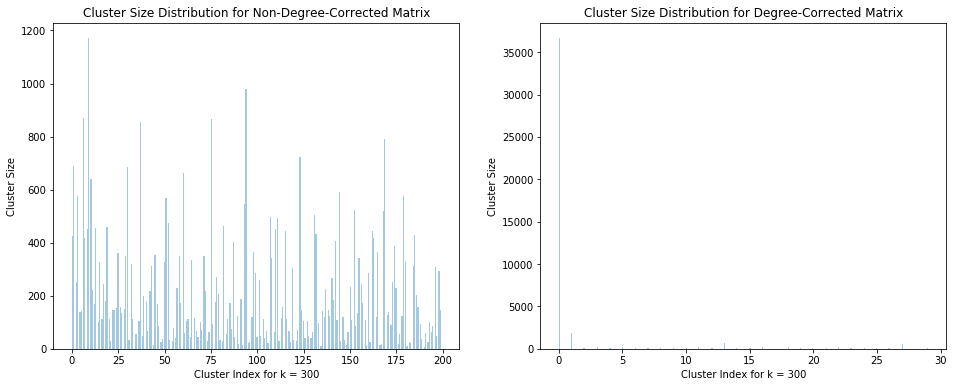

In [43]:
Y_cluster_labels = Y_cluster_labels_best
Y_mc_cluster_labels = Y_mc_cluster_labels_best

print(Y_cluster_labels.shape, Y_mc_cluster_labels.shape)
plt.figure(figsize=(16,6))
cluster_size_dist_ax1 = plt.subplot(1, 2, 1)
sns.distplot(Y_cluster_labels, bins=knn_clusters, kde=False)
plt.title("Cluster Size Distribution for Non-Degree-Corrected Matrix")
plt.xlabel("Cluster Index for k = {}".format(knn_clusters))
plt.ylabel("Cluster Size")

# plt.figure(figsize=(5,5))
cluster_size_dist_ax2 = plt.subplot(1, 2, 2)
sns.distplot(Y_mc_cluster_labels, bins=knn_clusters, kde=False)
plt.title("Cluster Size Distribution for Degree-Corrected Matrix")
plt.xlabel("Cluster Index for k = {}".format(knn_clusters))
plt.ylabel("Cluster Size")

In [44]:
def cluster_size_quartiles(cluster_labels): 
    cluster_label_counts = Counter(cluster_labels).items()
    cluster_labels = [p[0] for p in cluster_label_counts]
    cluster_sizes = [p[1] for p in cluster_label_counts]
    return (np.quantile(cluster_sizes, 0.25), np.quantile(cluster_sizes, 0.75))

Y_cluster_size_IQR = cluster_size_quartiles(Y_cluster_labels)
Y_mc_cluster_size_IQR = cluster_size_quartiles(Y_mc_cluster_labels)

Y_small_cluster_size = int(Y_cluster_size_IQR[0])
Y_large_cluster_size = int(Y_cluster_size_IQR[1])

Y_mc_small_cluster_size = int(Y_mc_cluster_size_IQR[0])
Y_mc_large_cluster_size = int(Y_mc_cluster_size_IQR[1])

"""
NOTE: Even though Y_mc yields a high silhouette score, its clusters are poor. 

This can be seen in the distribution of cluster sizes, where k_means yields 1 massive cluster
"""

print("Y Cluster Size IQR:", Y_cluster_size_IQR)
print("Y_mc Cluster Size IQR:", Y_mc_cluster_size_IQR)

Y Cluster Size IQR: (57.75, 321.5)
Y_mc Cluster Size IQR: (65.5, 211.25)


In [50]:
"""Double check cluster sizes"""
Y_small_clusters = []
Y_medium_clusters = []
Y_large_clusters = []
for i in range(Y_knn_clusters):
    cluster_size = cluster_assignments[cluster_assignments['CLUSTER'] == i].shape[0]
    if cluster_size <= Y_small_cluster_size:
        Y_small_clusters.append(i)
    elif cluster_size >= Y_large_cluster_size:
        Y_large_clusters.append(i)
    else:
        Y_medium_clusters.append(i)

In [51]:
print(Y_small_clusters)
print(Y_medium_clusters)
print(Y_large_clusters)

[21, 31, 34, 35, 38, 44, 48, 49, 53, 54, 56, 64, 68, 73, 80, 81, 83, 88, 90, 92, 95, 96, 100, 102, 104, 106, 112, 118, 120, 121, 126, 128, 129, 134, 145, 147, 148, 159, 161, 166, 167, 176, 177, 181, 182, 183, 189, 190, 192, 197]
[2, 4, 5, 11, 12, 14, 16, 17, 18, 20, 22, 23, 24, 26, 27, 28, 32, 33, 36, 39, 40, 41, 42, 43, 46, 47, 55, 57, 59, 61, 62, 63, 66, 67, 69, 70, 72, 74, 76, 77, 78, 79, 84, 85, 86, 89, 91, 97, 99, 101, 103, 105, 109, 113, 114, 116, 117, 119, 122, 124, 125, 127, 130, 133, 135, 136, 137, 138, 139, 140, 141, 143, 146, 149, 150, 151, 153, 154, 156, 157, 158, 160, 164, 170, 171, 172, 173, 175, 178, 184, 186, 187, 188, 191, 193, 194, 195, 196, 198, 199]
[0, 1, 3, 6, 7, 8, 9, 10, 13, 15, 19, 25, 29, 30, 37, 45, 50, 51, 52, 58, 60, 65, 71, 75, 82, 87, 93, 94, 98, 107, 108, 110, 111, 115, 123, 131, 132, 142, 144, 152, 155, 162, 163, 165, 168, 169, 174, 179, 180, 185]


In [53]:
Y_small_clusters = Y_small_clusters[:10]
Y_medium_clusters = Y_medium_clusters[:10]
Y_large_clusters = Y_large_clusters[:10]

No data found for ICD code V721


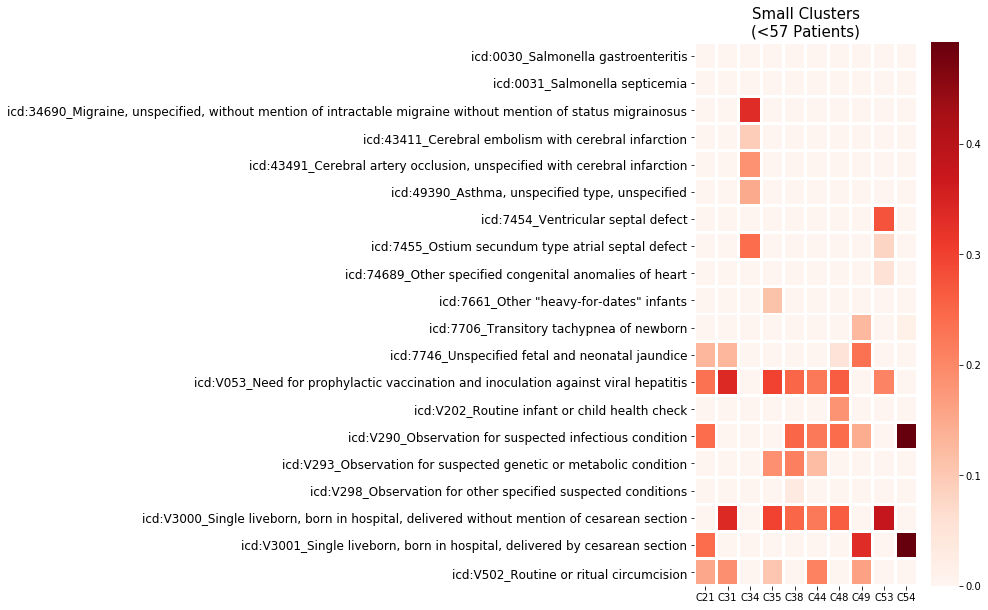

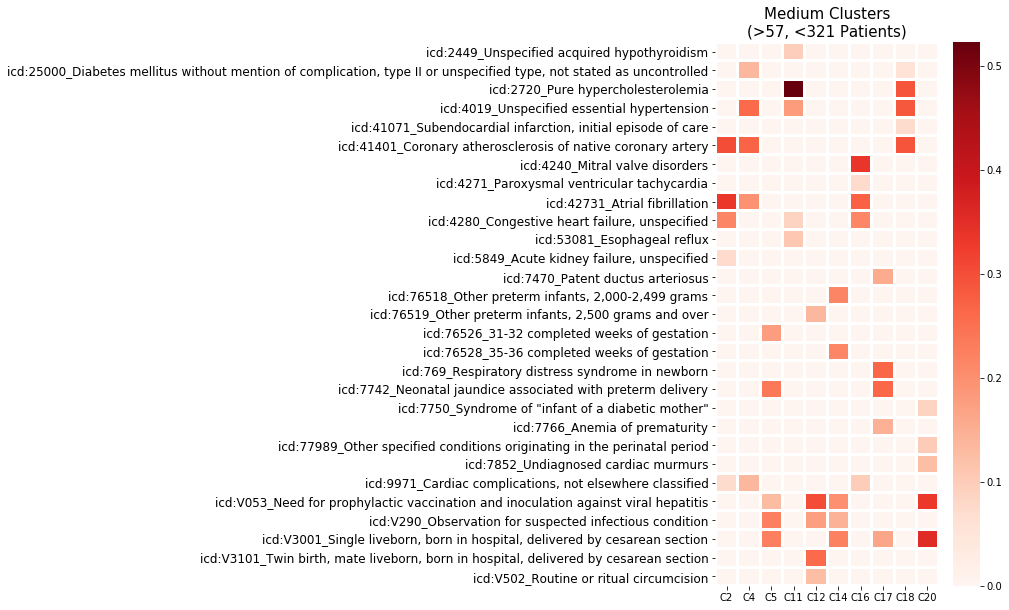

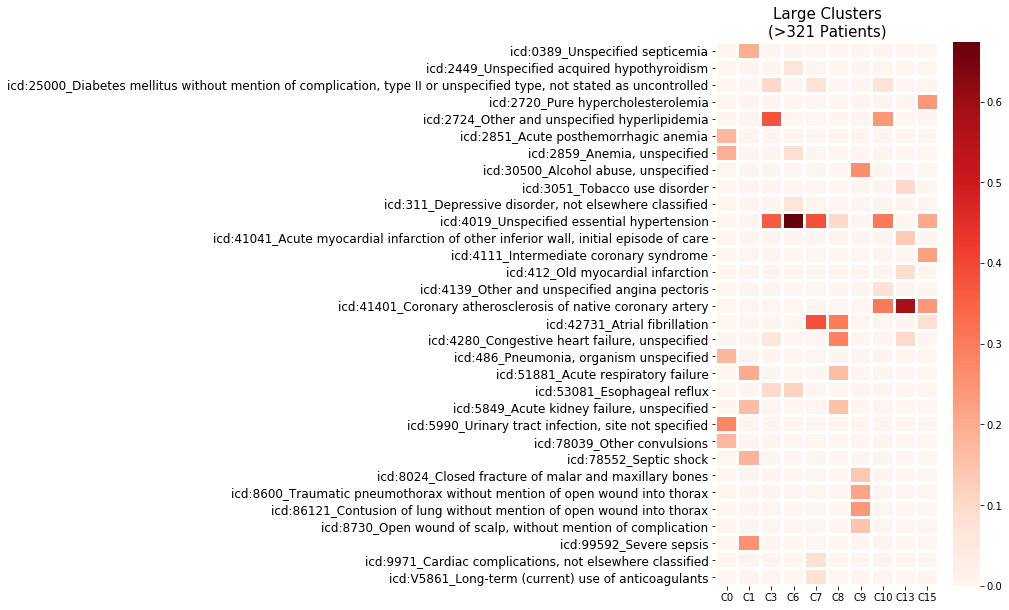

In [54]:
Y_small_clusters_percentages_df = feats_for_clusters(Y_small_clusters)
heatmap_clusters(Y_small_clusters_percentages_df, 
                 title="Small Clusters\n(<{} Patients)".format(Y_small_cluster_size))

Y_medium_clusters_percentages_df = feats_for_clusters(Y_medium_clusters)
heatmap_clusters(Y_medium_clusters_percentages_df, 
                 title="Medium Clusters\n(>{}, <{} Patients)".format(Y_small_cluster_size, Y_large_cluster_size))

Y_large_clusters_percentages_df = feats_for_clusters(Y_large_clusters)
heatmap_clusters(Y_large_clusters_percentages_df, 
                 title="Large Clusters\n(>{} Patients)".format(Y_large_cluster_size))

### PheCode analysis

In [58]:
icd_phecode_name_mapping = pd.read_csv('./data/icd9_phecode_mapping.csv', dtype={"phecode":str})

In [56]:
def load_phecode_file(file):
    col_names = pd.read_csv(file, nrows=0).columns
    types_dict = {'ICD9': str, 'PheCode': str}
    types_dict.update({col: str for col in col_names})
    icd_to_phecode = pd.read_csv(file, dtype=types_dict)
    return icd_to_phecode.rename(columns={'ICD9': 'icd9', 
                                          'PheCode': 'phecode', 
                                          'Phenotype': 'phenotype'})

def remove_decimals_from_phecodes(phecode):
    pos = phecode.find(".")
    if pos == -1:
        return phecode
    else:
        shortened_phecode = phecode[:pos]
        #if this shortened phecode does not exist
        if len(phecode_defs[phecode_defs['phecode'] == shortened_phecode]) == 0:
            return phecode
        return shortened_phecode
    
def add_phenotype_names(phecode):
    phenotype = phecode_defs[phecode_defs["phecode"] == phecode]['phenotype'].values[0]
    return phenotype
"""
icd_to_phecode = load_phecode_file("phecode_icd9_rolled.csv")
phecode_defs = load_phecode_file("phecode_definitions.csv")

#Remove periods from icd9codes
icd_to_phecode['icd9'] = icd_to_phecode["icd9"].apply(func=lambda x: x.replace(".", ""))

icd_to_phecode_no_decimals = icd_to_phecode.copy()
icd_to_phecode_no_decimals['phecode'] = icd_to_phecode_no_decimals['phecode'].apply(func=remove_decimals_from_phecodes)

#Only keep phecodes with corresponding / existing ICD codes
icd_phecode_name_mapping = icd_to_phecode_no_decimals[icd_to_phecode_no_decimals['icd9'].isin(icd9codes['ICD9_CODE'])]
icd_phecode_name_mapping['phenotype'] = icd_phecode_name_mapping['phecode'].apply(func=add_phenotype_names)

icd_phecode_name_mapping.to_csv("./data/icd9_phecode_mapping.csv", index=False)
"""

'\nicd_to_phecode = load_phecode_file("phecode_icd9_rolled.csv")\nphecode_defs = load_phecode_file("phecode_definitions.csv")\n\n#Remove periods from icd9codes\nicd_to_phecode[\'icd9\'] = icd_to_phecode["icd9"].apply(func=lambda x: x.replace(".", ""))\n\nicd_to_phecode_no_decimals = icd_to_phecode.copy()\nicd_to_phecode_no_decimals[\'phecode\'] = icd_to_phecode_no_decimals[\'phecode\'].apply(func=remove_decimals_from_phecodes)\n\n#Only keep phecodes with corresponding / existing ICD codes\nicd_phecode_name_mapping = icd_to_phecode_no_decimals[icd_to_phecode_no_decimals[\'icd9\'].isin(icd9codes[\'ICD9_CODE\'])]\nicd_phecode_name_mapping[\'phenotype\'] = icd_phecode_name_mapping[\'phecode\'].apply(func=add_phenotype_names)\n\nicd_phecode_name_mapping.to_csv("./data/icd9_phecode_mapping.csv", index=False)\n'

In [62]:
updated_phecode_idx_mapping = dict(phecode_feat_idx_mapping)

def get_phecode_and_phenotype_from_icd9(icd9):    
    phecode = icd_phecode_name_mapping[icd_phecode_name_mapping['icd9'] == icd9]['phecode'].values[0]
    phenotype = icd_phecode_name_mapping[icd_phecode_name_mapping['icd9'] == icd9]['phenotype'].values[0]
    return (phecode, phenotype)

def phecode_distribution_for_cluster_i(cluster_i): 
    pidx_in_cluster_i = cluster_assignments[cluster_assignments["CLUSTER"] == cluster_i]['ORIGINAL_INDEX']
    pfeats_in_cluster_i = patient_icd_binary[pidx_in_cluster_i]
    pfeats_distr_in_cluster_i = np.asarray(pfeats_in_cluster_i.sum(axis=0))

    icd9codes_aslist = icd9codes["ICD9_CODE"].tolist()

    icd_freq_pairs_in_cluster_i = list(zip(icd9codes_aslist, pfeats_distr_in_cluster_i[0]))
    icd_freq_pairs_in_cluster_i = sorted(icd_freq_pairs_in_cluster_i, key=lambda p: p[1], reverse=True)
    icd_freq_pairs_in_cluster_i_nonzeros = [p for p in icd_freq_pairs_in_cluster_i if p[1] > 0]
    icd_freq_pairs_in_cluster_i = icd_freq_pairs_in_cluster_i_nonzeros

    #List[ ((phecode, phenotype), freq) ]
    phecode_phenotype_freq_pairs_in_cluster_i = {}
    for pair in icd_freq_pairs_in_cluster_i:
        icd9 = pair[0]
        freq = pair[1]

        try:
            phecode_phenotype = get_phecode_and_phenotype_from_icd9(icd9)
            
            if phecode_phenotype not in phecode_phenotype_freq_pairs_in_cluster_i:
                phecode_phenotype_freq_pairs_in_cluster_i[phecode_phenotype] = freq
            else:
                phecode_phenotype_freq_pairs_in_cluster_i[phecode_phenotype] += freq
        except:
            
            icd9_longtitle = icd9diag[icd9diag['ICD9_CODE'] == 'V3001']['LONG_TITLE'].values[0]
            icd9_phecode_substitute = "icd9:{}".format(icd9)
            phecode_phenotype = (icd9_phecode_substitute, icd9_longtitle)
            
            if icd9_phecode_substitute not in updated_phecode_idx_mapping:
                updated_phecode_idx_mapping[icd9_phecode_substitute] = np.max(list(updated_phecode_idx_mapping.values())) + 1
            
            if phecode_phenotype not in phecode_phenotype_freq_pairs_in_cluster_i:
                phecode_phenotype_freq_pairs_in_cluster_i[phecode_phenotype] = freq
            else:
                phecode_phenotype_freq_pairs_in_cluster_i[phecode_phenotype] += freq
        
    return phecode_phenotype_freq_pairs_in_cluster_i

def phecode_dist_from_phecode_freqs(phecode_phenotype_freq_pairs_in_cluster_i):
    phecode_counts = sorted(phecode_phenotype_freq_pairs_in_cluster_i.items(), key=lambda p: p[1], reverse=True)

    #Make list that is plotable
    phecode_distribution = []
    for idx, pair in enumerate(phecode_counts):
        phecode_frequency = pair[1]
        phecode_distribution += [idx] * phecode_frequency
    return phecode_distribution

def cluster_entropy_from_dist(dist):
    counts = Counter(dist)
    counts = [p[1] for p in counts.most_common()]
    return entropy(counts)

In [63]:
Y_knn_clusters

200

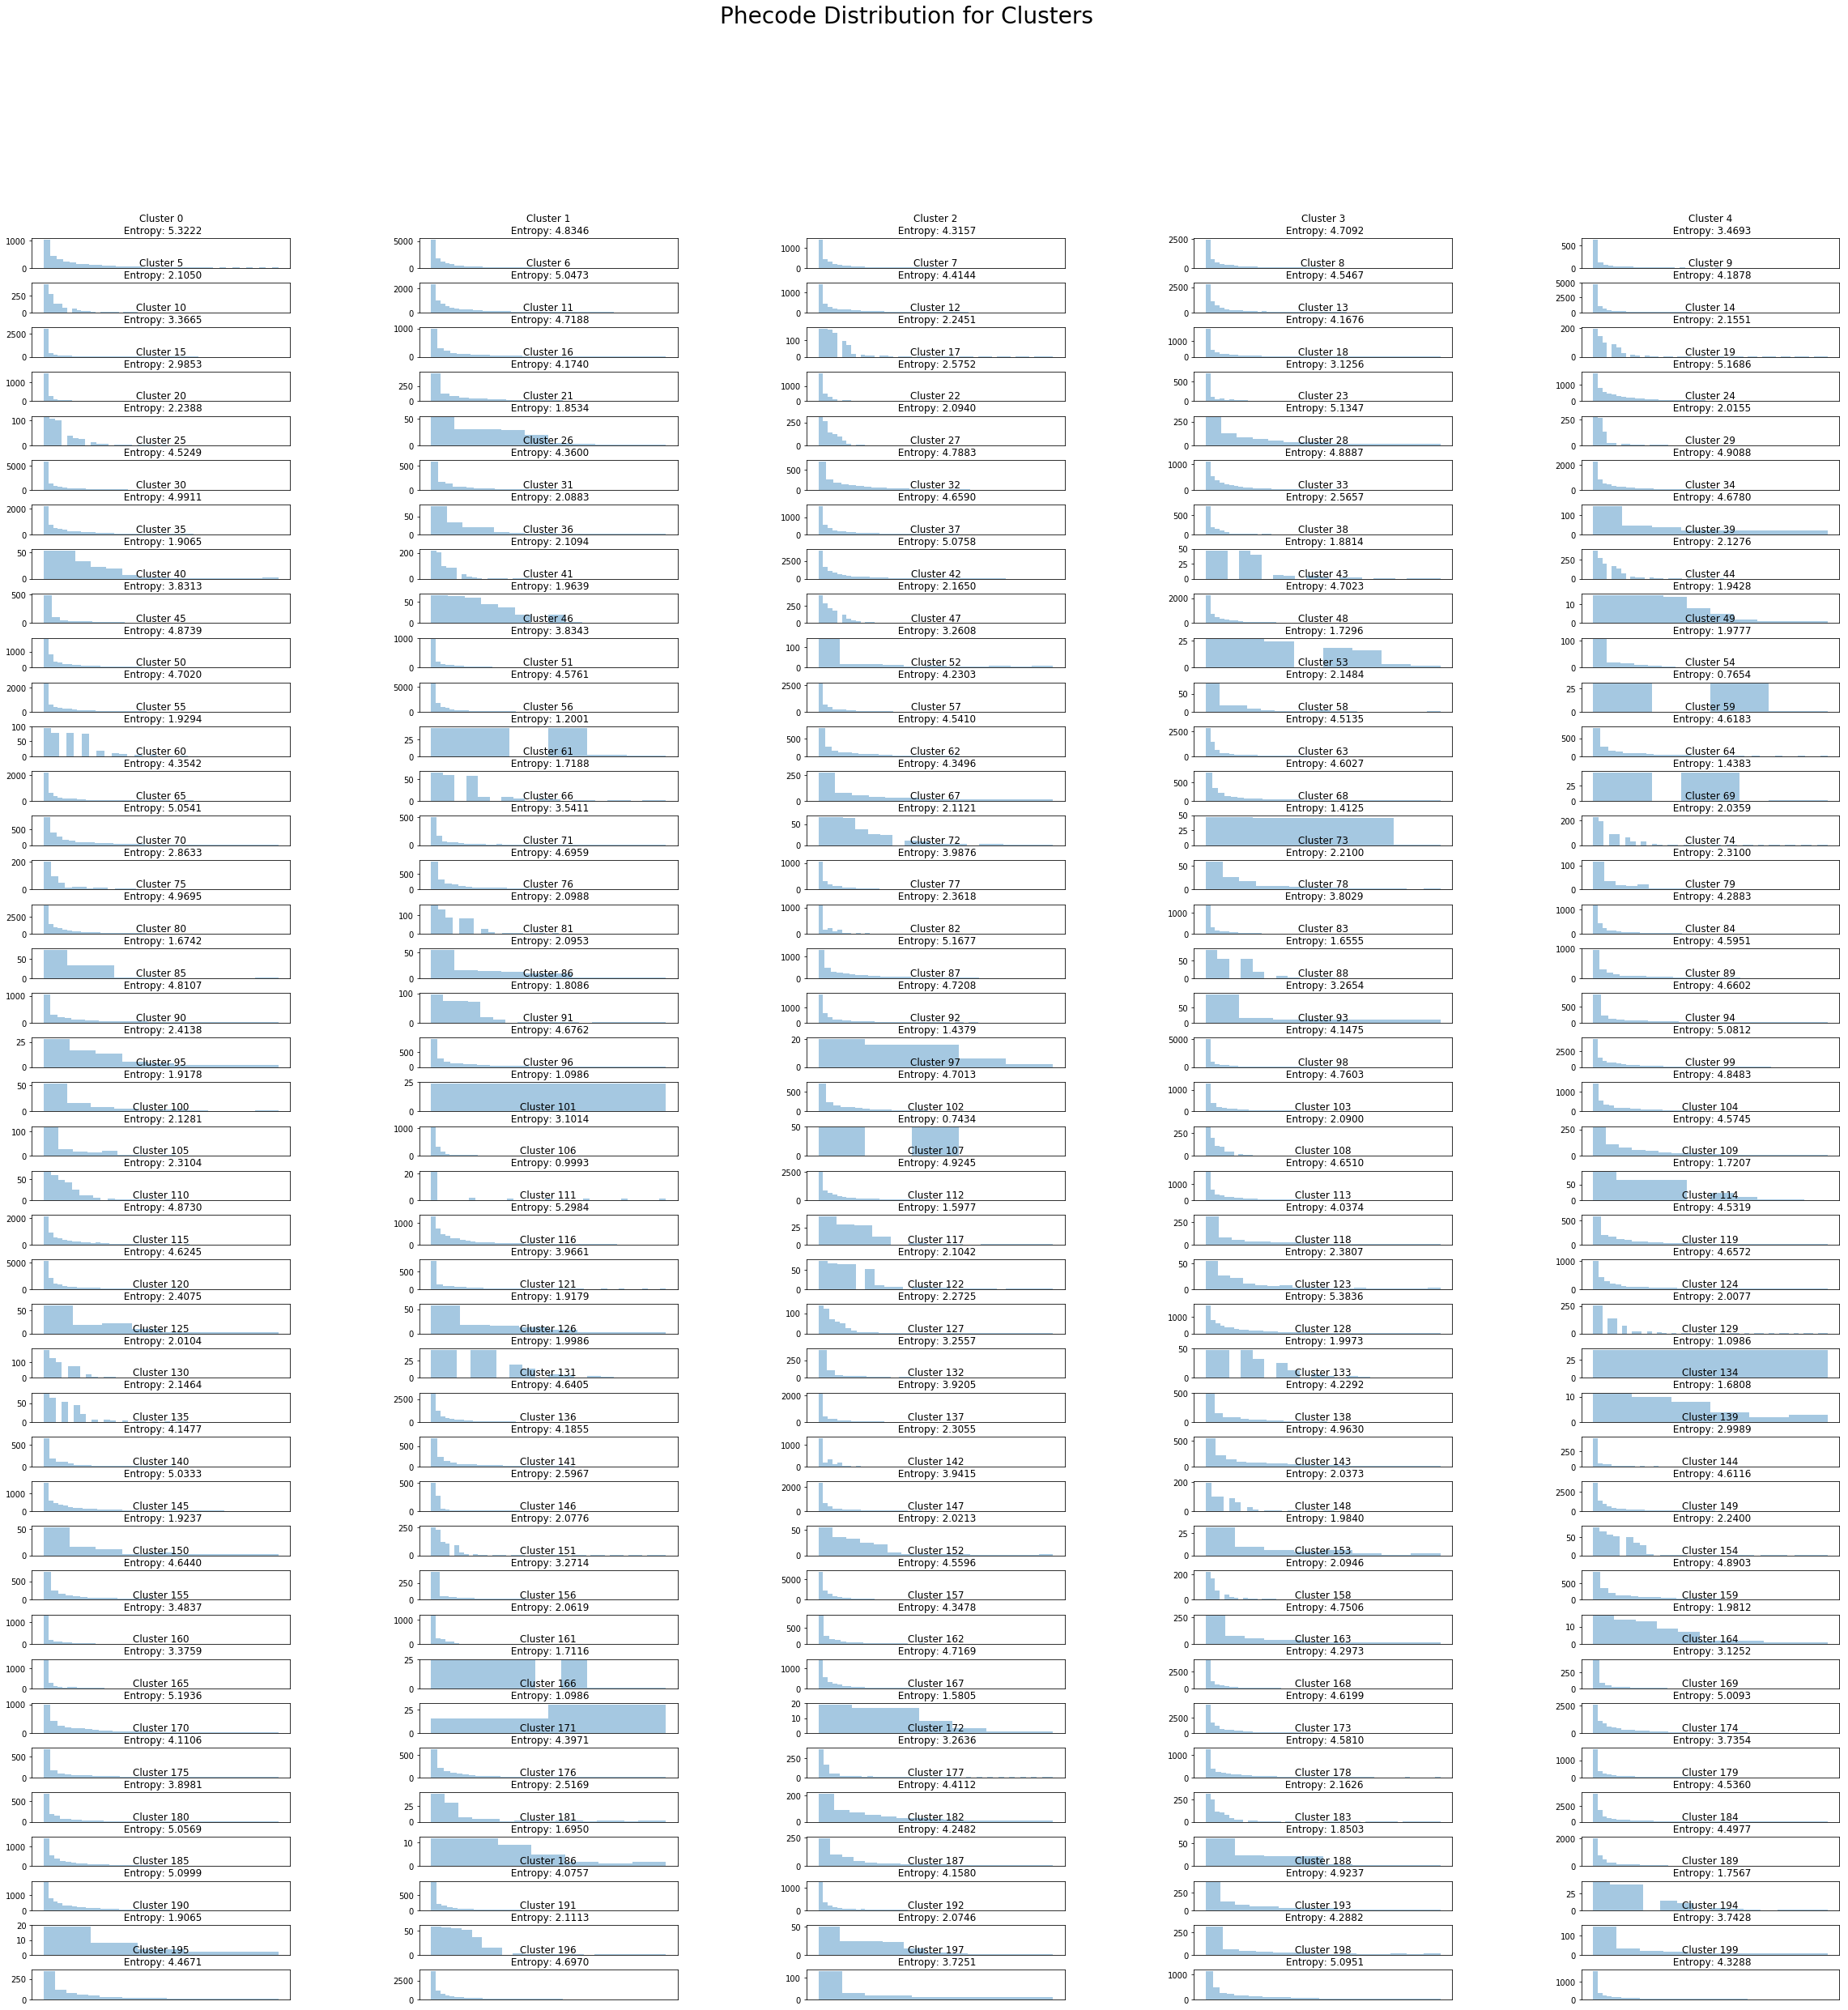

In [64]:
fig = plt.figure(figsize=(40,40))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle("Phecode Distribution for Clusters", fontsize=28)

for cluster_i in range(Y_knn_clusters):
    phecode_phenotype_freq_pairs_in_cluster_i = phecode_distribution_for_cluster_i(cluster_i)
    phecode_dist = phecode_dist_from_phecode_freqs(phecode_phenotype_freq_pairs_in_cluster_i)
    
    e = cluster_entropy_from_dist(phecode_dist)
    
    ax_subplot = fig.add_subplot(Y_knn_clusters/5, 5, cluster_i + 1)
    ax_subplot.title.set_text("Cluster {}\n Entropy: {:.4f}".format(cluster_i, e))
    ax_sns = sns.distplot(phecode_dist, kde=False)
    ax_sns.set_xticks([])
    
pickle.dump(updated_phecode_idx_mapping, open("./data/updated_phecode_idx_mapping_k{}.p".format(Y_knn_clusters), 'wb'))
plt.savefig("./tests/phecode_dist_k{}_NOT_mc.png".format(Y_knn_clusters))

In [65]:
"""Inspect cluster with highest entropy"""
ci = 140
highest_entropy_phecode_phenotype_freq_pairs = phecode_distribution_for_cluster_i(ci)
highest_entropy_phecode_dist = phecode_dist_from_phecode_freqs(highest_entropy_phecode_phenotype_freq_pairs)
e = cluster_entropy_from_dist(highest_entropy_phecode_dist)

highest_entropy_phecode_counts = sorted(highest_entropy_phecode_phenotype_freq_pairs.items(), key=lambda p: p[1], reverse=True)
highest_entropy_phecode_counts

[(('401', 'Hypertension'), 279),
 (('272', 'Disorders of lipoid metabolism'), 249),
 (('276', 'Disorders of fluid, electrolyte, and acid-base balance'), 246),
 (('250', 'Diabetes mellitus'), 143),
 (('285', 'Other anemias'), 136),
 (('038', 'Septicemia'), 124),
 (('585', 'Renal failure'), 122),
 (('509', 'Respiratory failure, insufficiency, arrest'), 116),
 (('994', 'Sepsis and SIRS'), 100),
 (('041', 'Bacterial infection NOS'), 75),
 (('530', 'Diseases of esophagus'), 74),
 (('411', 'Ischemic Heart Disease'), 72),
 (('797', 'Shock'), 67),
 (('591', 'Urinary tract infection'), 62),
 (('480', 'Pneumonia'), 60),
 (('427', 'Cardiac dysrhythmias'), 60),
 (('318', 'Tobacco use disorder'), 58),
 (('198', 'Secondary malignant neoplasm'), 57),
 (('707', 'Chronic ulcer of skin'), 56),
 (('577', 'Diseases of pancreas'), 53),
 (('286', 'Coagulation defects'), 53),
 (('452', 'Other venous embolism and thrombosis'), 53),
 (('428', 'Congestive heart failure; nonhypertensive'), 52),
 (('317', 'Alcoho

### Silhouette Analysis

In [66]:
Y_feats_sil = 300
Y_knn_clusters_sil = 200

Y_sil = pickle.load(open("./data/Y_f20.p", 'rb'))
Y_cluster_labels_sil = pickle.load(open("./data/cluster_labels_Y_{}feats_k{}.p".format(Y_feats_sil, Y_knn_clusters_sil), 'rb'))

In [67]:
highest_entropy_cluster = 140

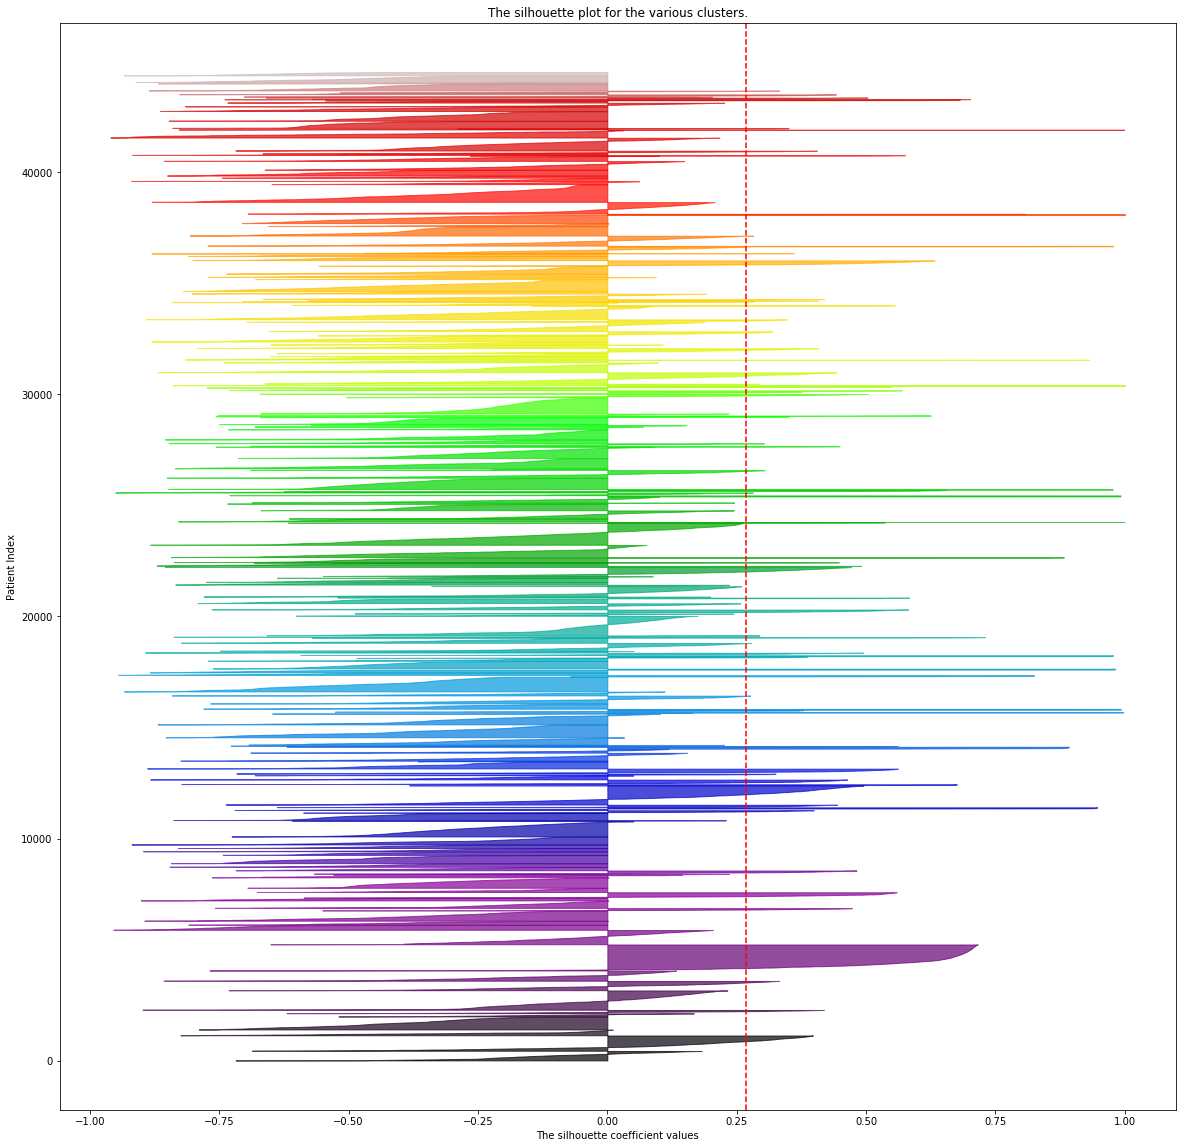

In [68]:
"""
Generate global silhouette plot
"""
import matplotlib.cm as cm

sample_silhouette_values = silhouette_samples(Y_sil, Y_cluster_labels_sil)

cluster_labels = Y_cluster_labels_sil

y_lower = 10
n_clusters = Y_knn_clusters_sil

fig, ax1 = plt.subplots(1, 1, figsize=(20,20))

silhouette_avg = silhouette_score(Y, Y_cluster_labels)
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numb–ers at the middle
#     ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Patient Index")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

# ax1.set_yticks([])  # Clear the yaxis labels / ticks
# ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.savefig("./tests/silplot_ALL_f{}_k{}.png".format(Y_feats_sil, Y_knn_clusters_sil))

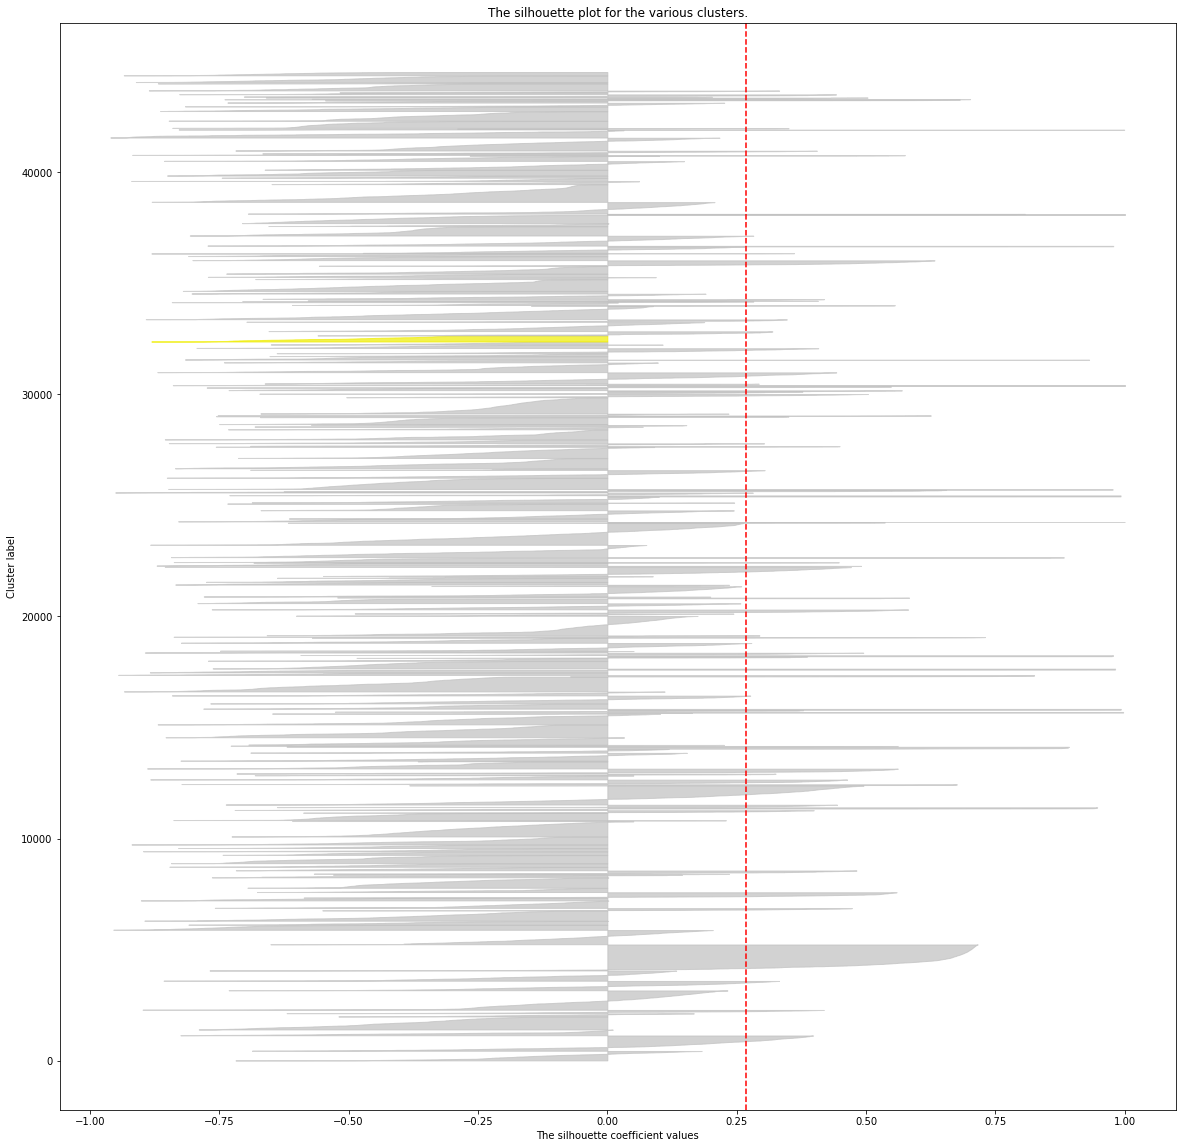

In [69]:
""" Highlight single cluster """
sample_silhouette_values = silhouette_samples(Y_sil, Y_cluster_labels_sil)

cluster_labels = Y_cluster_labels_sil

y_lower = 10
n_clusters = Y_knn_clusters_sil

fig, ax1 = plt.subplots(1, 1, figsize=(20,20))

silhouette_avg = silhouette_score(Y, Y_cluster_labels)

for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    if i == highest_entropy_cluster:
        color = cm.nipy_spectral(float(i) / n_clusters)
    else:
        color = "silver"
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numb–ers at the middle
#     ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

# ax1.set_yticks([])  # Clear the yaxis labels / ticks
# ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.savefig("./tests/silplot_c{}_f{}_k{}.png".format(highest_entropy_cluster, Y_feats_sil, Y_knn_clusters_sil))

### GephI CSV's 

Build Jaccard adjacency matrix 

In [60]:
phecode_feat_idx_mapping = pickle.load(open("./data/updated_phecode_idx_mapping.p", 'rb'))

def phecode_feature_vector(ci):
    phecode_phenotype_freq_pairs_in_cluster_i = phecode_distribution_for_cluster_i(ci)
    phecode_phenotype_freq_tuples_in_cluster_i = sorted(phecode_phenotype_freq_pairs_in_cluster_i.items(), key=lambda p: p[1], reverse=True)
    
    feat_vec = np.zeros(len(phecode_feat_idx_mapping))
    for phecode_phenotype, freq in phecode_phenotype_freq_tuples_in_cluster_i:
        phecode = phecode_phenotype[0]
        phecode_feat_idx = phecode_feat_idx_mapping[phecode]
        feat_vec[phecode_feat_idx] = freq
    return feat_vec

phecode_featvecs = {}
def weighted_jaccard_similarity(ci1, ci2):
    
    if ci1 in phecode_featvecs:
        phecode_f1 = phecode_featvecs[ci1]
    else:
        phecode_f1 = phecode_feature_vector(ci1)
        phecode_featvecs[ci1] = phecode_f1

    if ci2 in phecode_featvecs:
        phecode_f2 = phecode_featvecs[ci2]
    else:
        phecode_f2 = phecode_feature_vector(ci2)
        phecode_featvecs[ci2] = phecode_f2
        
    
    f1_f2_matrix = np.vstack([phecode_f1, phecode_f2])
    jaccard_num = np.sum(np.amin(f1_f2_matrix, axis=0))
    jaccard_den = np.sum(np.amax(f1_f2_matrix, axis=0))

    j_weighted_score = jaccard_num / jaccard_den
    
    return j_weighted_score

In [302]:
colnames = ['c{}'.format(i) for i in range(Y_knn_clusters)]

jaccard_adj_matrix = np.zeros((Y_knn_clusters,Y_knn_clusters))
for ci1 in range(Y_knn_clusters):
    for ci2 in range(Y_knn_clusters):
        jaccard_adj_matrix[ci1, ci2] = weighted_jaccard_similarity(ci1, ci2)

jaccard_adj_matrix_df = pd.DataFrame(data=jaccard_adj_matrix, columns=colnames)
jaccard_adj_matrix_df.to_csv("./data/adj_matrix_jaccardsim_NOT_mc.csv", index=False)

In [303]:
jaccard_adj_matrix_df = pd.read_csv("./data/adj_matrix_jaccardsim_NOT_mc.csv")
jaccard_adj_matrix_df

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c40,c41,c42,c43,c44,c45,c46,c47,c48,c49
0,1.000000,0.253213,0.022461,0.526113,0.003694,0.002197,0.324924,0.184504,0.456655,0.004805,...,0.273164,0.011339,0.001922,0.043395,0.001297,0.003410,0.396689,0.001099,0.002000,0.567370
1,0.253213,1.000000,0.024142,0.344360,0.003110,0.001799,0.689994,0.478264,0.375467,0.006350,...,0.783419,0.019631,0.001319,0.061590,0.000655,0.003262,0.513541,0.001076,0.001555,0.386586
2,0.022461,0.024142,1.000000,0.017746,0.152346,0.048905,0.024136,0.016983,0.019116,0.058006,...,0.025038,0.014521,0.058592,0.018507,0.019824,0.151985,0.021552,0.015289,0.015282,0.020637
3,0.526113,0.344360,0.017746,1.000000,0.002467,0.001533,0.464054,0.292567,0.672293,0.002985,...,0.367707,0.008538,0.001304,0.032546,0.000850,0.002465,0.583552,0.000851,0.001378,0.707033
4,0.003694,0.003110,0.152346,0.002467,1.000000,0.221311,0.003117,0.002343,0.002576,0.216378,...,0.003197,0.037337,0.266691,0.013089,0.093617,0.363124,0.003025,0.066125,0.068006,0.003287
5,0.002197,0.001799,0.048905,0.001533,0.221311,1.000000,0.001613,0.001307,0.001471,0.520796,...,0.001614,0.074613,0.491703,0.010072,0.395013,0.290385,0.001619,0.245922,0.275510,0.002039
6,0.324924,0.689994,0.024136,0.464054,0.003117,0.001613,1.000000,0.469112,0.516743,0.005511,...,0.758185,0.016100,0.001187,0.056968,0.000658,0.003241,0.703536,0.000991,0.001416,0.483844
7,0.184504,0.478264,0.016983,0.292567,0.002343,0.001307,0.469112,1.000000,0.376395,0.004215,...,0.455066,0.012644,0.000992,0.038526,0.000508,0.002629,0.447343,0.000863,0.000902,0.267900
8,0.456655,0.375467,0.019116,0.672293,0.002576,0.001471,0.516743,0.376395,1.000000,0.003670,...,0.406924,0.008812,0.001287,0.034512,0.000743,0.002623,0.702222,0.000899,0.001362,0.546907
9,0.004805,0.006350,0.058006,0.002985,0.216378,0.520796,0.005511,0.004215,0.003670,1.000000,...,0.006310,0.074045,0.458787,0.020646,0.283629,0.300112,0.004397,0.209375,0.210363,0.004130


Make Node, Edges CSVs for Gephi

In [304]:
len(phecode_feat_idx_mapping)

1110

In [61]:
phecode_feat_idx_mapping = [(phecode, idx) for idx, phecode in enumerate(icd_phecode_name_mapping['phecode'].unique())]
phecode_feat_idx_mapping = dict(phecode_feat_idx_mapping)
pickle.dump(phecode_feat_idx_mapping, open("./data/phecode_feat_idx_mapping.p", 'wb'))


In [306]:
"""
Get top phecode in each cluster
"""
top_phecode_phenotype_in_each_cluster = []
for ci in tqdm(range(Y_knn_clusters)):
    phecode_phenotype_freq_pairs_in_cluster_i = phecode_distribution_for_cluster_i(ci)
    most_common_phecode_phenotype = max(phecode_phenotype_freq_pairs_in_cluster_i.items(), key=lambda p: p[1])
    top_phecode_phenotype_in_each_cluster.append(most_common_phecode_phenotype)
print(top_phecode_phenotype_in_each_cluster)

100%|██████████| 50/50 [01:19<00:00,  1.60s/it]

[(('276', 'Disorders of fluid, electrolyte, and acid-base balance'), 1672), (('411', 'Ischemic Heart Disease'), 2681), (('656', 'Other perinatal conditions of fetus or newborn'), 5431), (('428', 'Congestive heart failure; nonhypertensive'), 1833), (('icd9:V3001', 'Single liveborn, born in hospital, delivered by cesarean section'), 508), (('656', 'Other perinatal conditions of fetus or newborn'), 193), (('411', 'Ischemic Heart Disease'), 1923), (('411', 'Ischemic Heart Disease'), 6703), (('401', 'Hypertension'), 2905), (('656', 'Other perinatal conditions of fetus or newborn'), 236), (('411', 'Ischemic Heart Disease'), 27), (('276', 'Disorders of fluid, electrolyte, and acid-base balance'), 1678), (('1010', 'Other tests'), 62), (('430', 'Intracranial hemorrhage'), 98), (('1010', 'Other tests'), 46), (('1010', 'Other tests'), 48), (('icd9:V3000', 'Single liveborn, born in hospital, delivered by cesarean section'), 65), (('icd9:V3001', 'Single liveborn, born in hospital, delivered by cesa

In [307]:
#Looking for number of most common codes
top_phecodes_in_each_cluster = [p[0] for p in top_phecode_phenotype_in_each_cluster]
print(len(Counter(top_phecodes_in_each_cluster).keys()))
print(Counter(top_phecodes_in_each_cluster).values())

13
dict_values([4, 10, 7, 2, 3, 3, 6, 2, 7, 3, 1, 1, 1])


In [308]:
"""Color mapping for Gephi CSV"""

phecode_color_idx = enumerate(Counter(top_phecodes_in_each_cluster).keys())
phecode_color_idx = dict([(i, phec_phen) for phec_phen, i in phecode_color_idx])
print(phecode_color_idx)
nodes_colors = [phecode_color_idx[tup] for tup in top_phecodes_in_each_cluster]
print(len(nodes_colors))

{('276', 'Disorders of fluid, electrolyte, and acid-base balance'): 0, ('411', 'Ischemic Heart Disease'): 1, ('656', 'Other perinatal conditions of fetus or newborn'): 2, ('428', 'Congestive heart failure; nonhypertensive'): 3, ('icd9:V3001', 'Single liveborn, born in hospital, delivered by cesarean section'): 4, ('401', 'Hypertension'): 5, ('1010', 'Other tests'): 6, ('430', 'Intracranial hemorrhage'): 7, ('icd9:V3000', 'Single liveborn, born in hospital, delivered by cesarean section'): 8, ('637', 'Short gestation; low birth weight; and fetal growth retardation'): 9, ('1008', 'Crushing or internal injury to organs'): 10, ('427', 'Cardiac dysrhythmias'): 11, ('icd9:V290', 'Single liveborn, born in hospital, delivered by cesarean section'): 12}
50


In [309]:
cluster_sizes = sorted(Counter(Y_cluster_labels).items(), key=lambda x: x[0])
cluster_sizes = [p[1] for p in cluster_sizes]
print(cluster_sizes)

[2201, 1406, 1609, 2001, 510, 149, 1580, 3158, 3065, 195, 32, 1578, 62, 105, 63, 48, 65, 108, 1060, 2316, 46, 48, 36, 2762, 45, 1612, 28, 44, 282, 48, 1856, 36, 90, 5532, 43, 2282, 286, 23, 53, 33, 1364, 43, 200, 232, 60, 395, 2176, 57, 52, 1442]


In [311]:
nodes_labels = []
for phecode, phenotype in top_phecodes_in_each_cluster:
    node_label = "({}, {})".format(phecode, phenotype)
    nodes_labels.append(node_label)
print(nodes_labels[0])

nodes_dict = {"Id": [i for i in range(Y_knn_clusters)], 
              "Label": nodes_labels,
              "Size": cluster_sizes, 
              "Color": nodes_colors}
nodes_df = pd.DataFrame(nodes_dict)
nodes_df.to_csv("./tests/nodes{}.csv".format(Y_knn_clusters), index=False)
nodes_df = pd.read_csv("./tests/nodes{}.csv".format(Y_knn_clusters))
nodes_df.head()

(276, Disorders of fluid, electrolyte, and acid-base balance)


,Id,Label,Size,Color
0,0,"(276, Disorders of fluid, electrolyte, and aci...",2201,0
1,1,"(411, Ischemic Heart Disease)",1406,1
2,2,"(656, Other perinatal conditions of fetus or n...",1609,2
3,3,"(428, Congestive heart failure; nonhypertensive)",2001,3
4,4,"(icd9:V3001, Single liveborn, born in hospital...",510,4


In [312]:
edges_sources = []
for i in range(Y_knn_clusters):
    edges_sources += [i] * Y_knn_clusters

edges_targets = list(range(Y_knn_clusters)) * Y_knn_clusters
edges_types = ["Undirected"] * Y_knn_clusters * Y_knn_clusters
edges_ids = list(range(Y_knn_clusters * Y_knn_clusters))

edges_weights = []
for i in range(Y_knn_clusters):
    edges_weights += jaccard_adj_matrix_df.iloc[i].values.tolist()

print(len(edges_sources))
print(len(edges_targets))
print(len(edges_types))
print(len(edges_ids))
print(len(edges_weights))

edges_dict = {"Source": edges_sources, 
              "Target": edges_targets, 
              "Type": edges_types, 
              "Id": edges_ids, 
              "Weight": edges_weights}

edges_df = pd.DataFrame(edges_dict)
sim_thresh = 0
edges_df = edges_df[edges_df["Weight"] > sim_thresh]

edges_df.to_csv("./tests/edges{}.csv".format(Y_knn_clusters), index=False)
edges_df = pd.read_csv("./tests/edges{}.csv".format(Y_knn_clusters))
edges_df.head()

2500
2500
2500
2500
2500


,Source,Target,Type,Id,Weight
0,0,0,Undirected,0,1.000000
1,0,1,Undirected,1,0.253213
2,0,2,Undirected,2,0.022461
3,0,3,Undirected,3,0.526113
4,0,4,Undirected,4,0.003694
